# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [3]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

In [104]:
len(text), str(text[:2500])

(3471475,
 'jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, its my feeling, youve gotta go. \n\n

## Check data for valid words and data lengths

In [105]:
english_words = {}
with open("dict/wordsEn.txt") as word_file:
    english_words = set(word.strip().lower() for word in word_file if len(word) > 0)
with open("dict/words.txt") as word_file:
    english_words = set(word.strip().lower() for word in word_file if len(word) > 0)  

In [106]:
english_words.add("o.k.")

In [107]:
def is_english_word(word):
    return 1 if word.lower() in english_words else 0

In [108]:
is_english_word("o.k.") 

1

In [109]:
import pandas as pd
import re as re
import operator
from collections import Counter

def uniqueratio(wcount, uwcount):
    if uwcount == 0:
        retval = 1.
    else:
        retval = wcount / uwcount
    return retval

def textDF (text):
    # Data and target as a data frame, with word count attributes
    DF = pd.DataFrame(text, columns = ["Text"])
    DF['Character'] = DF.Text.apply(lambda x: x[: x.find(':')])
    DF['Stripped'] = DF.Text.apply(lambda x: re.sub (r'([^a-zA-Z\s]+?)', '', x))
    DF['DataLength'] = DF.Stripped.apply(len)
    DF['WordCount'] = DF.Stripped.apply(lambda x: re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x)).apply(len)
    DF['EnglishPerc'] = DF.Stripped.apply(lambda x: [is_english_word(w) for w in x]).apply(sum) / DF.WordCount
    DF['WordsCounts'] = DF.Stripped.apply(lambda x: Counter(filter(None, re.split("[ \[\]\\n\@\-\"!?:,.()<>]+", x))))    
    DF['UniqueWords'] = DF['WordsCounts'].apply(len)
    DF['UniqueRatio'] = DF.apply(lambda x: uniqueratio(x['WordCount'], x['UniqueWords']), axis =1) 
    ## DF['NoPunctuation'] = DF.Text.apply(lambda x: ''.join(e for e in x if e.isalnum()))
    DF['DataIndex'] = DF.index
    DF = DF[['Text', 'Character', 'DataLength', 'WordCount', 'UniqueWords', 
             'Stripped', 'UniqueRatio', 'EnglishPerc', 'DataIndex', 'WordsCounts' ]]
    
    return DF

In [110]:
textSplit = text.split("\n\n")

In [111]:
Text_df = textDF(textSplit)

In [112]:
pd.set_option('display.max_colwidth', 80)
Text_df.head(5)

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc,DataIndex,WordsCounts
0,"jerry: do you know what this is all about? do you know, why were here? to be...",jerry,929,192,97,jerry do you know what this is all about do you know why were here to be out...,1.979381,3.843750,0,"{'jerry': 1, 'do': 4, 'you': 16, 'know': 3, 'what': 3, 'this': 3, 'is': 6, '..."
1,"jerry: (pointing at georges shirt) see, to me, that button is in the worst p...",jerry,220,43,33,jerry pointing at georges shirt see to me that button is in the worst possib...,1.303030,4.139535,1,"{'jerry': 1, 'pointing': 1, 'at': 2, 'georges': 1, 'shirt': 2, 'see': 1, 'to..."
2,george: are you through?,george,23,5,4,george are you through,1.250000,3.800000,2,"{'george': 1, 'are': 1, 'you': 1, 'through': 1}"
3,"jerry: you do of course try on, when you buy?",jerry,43,11,9,jerry you do of course try on when you buy,1.222222,3.000000,3,"{'jerry': 1, 'you': 2, 'do': 1, 'of': 1, 'course': 1, 'try': 1, 'on': 1, 'wh..."
4,"george: yes, it was purple, i liked it, i dont actually recall considering t...",george,83,16,13,george yes it was purple i liked it i dont actually recall considering the b...,1.230769,4.250000,4,"{'george': 1, 'yes': 1, 'it': 2, 'was': 1, 'purple': 1, 'i': 2, 'liked': 1, ..."


### Get unique names of Seinfield characters and feed into english words dict, then re-run dataframe...
- Wanting to identify rows with not much recognized English, but need to ensure the majority of the characters in the show are counted as English words...

In [113]:
charactersSet = set(list(Text_df.Character))

In [114]:
characters_df = pd.DataFrame(list(charactersSet), columns = ["Character"])

In [115]:
characters_df[characters_df.Character.str.len() < 30][:10]

,Character
0,
1,angry man
2,the girls
3,detective #2 (to kurt)
4,elaine (o.c.)
5,dx
6,tvvoice
7,elaine (uninterested)
9,voice
10,george (to clerk)


### Just use a name if its longer than zero and <= than 20

In [116]:
for character in characters_df.values:
    charac = character[0]
    bracketpos = charac.find('(')
    if bracketpos < 0:
        bracketpos = charac.find('[')
    if bracketpos >= 0:
        charac = charac[:bracketpos]
    if (len(charac) > 0) & (len(charac) <= 20):
        print(charac)
        english_words.add(charac)
        english_words.add(charac+":")

angry man
the girls
detective #2 
elaine 
dx
tvvoice
elaine 
george 
voice
george 
manager
puerto rican man
kramer 
nurse
michael
kramer + jerry
toby 
herb
elaine 
john tyler
cop #1
girlfriend
man1
stefanie
peterman 
executive 2
jessie
marisa
low-talker
counter woman
lindsay
charles
mark
jerry 
ian
man in audience
woman behind elaine
kid
police officer
harold
pitt 
mel
elaine 
wx
elaine 
showalter
mrs. c
bookman
jerry 
george 
jery
jerry 
george 
audience
postman
george 
earl
doorman 2
toby 
buzzer
cab driver
rental car agent
dr. dembrow
sue ellen
john
george wendt
woman at next table 
sharon
evelyn
hooker
walter
george 
alan
morty 
jerryÂ’s message
ellen
elaine 
jenna 
buckles
ms. jordan
sam
dustin
george 
vegetable lasagna
teddy
jerry 
jerry 
cop 2
george 
reilly
farkus
willie
jerry 
uncle leo 
kramer 
jerry 
al roker
bania
katie
female worker
tv
2nd movie patron
kid #2
boy
judge 
jerry 
donald
student 1
jerry 
all 
man 2
steven
estelle
celia
umpire
kramer & mickey
kathy lee
slippert

In [117]:
is_english_word("subway announcement")

1

### Re-create dataframe after adding character names to the english words dictionary...

In [118]:
Text_df = textDF(textSplit)

In [119]:
pd.set_option('display.max_colwidth', -1)

In [121]:
Text_df.loc[:10, :"Stripped"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped
0,"jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, its my feeling, youve gotta go.",jerry,929,192,97,jerry do you know what this is all about do you know why were here to be out this is outand out is one of the single most enjoyable experiences of life peopledid you ever hear people talking about we should go out this is what theyre talking aboutthis whole thing were all out now no one is home not one person here is home were all out there are people trying to find us they dont know where we are on an imaginary phone did you ring i cant find him where did he go he didnt tell me where he was going he must have gone out you wanna go out you get ready you pick out the clothes right you take the shower you get all ready get the cash get your friends the car the spot the reservationthen youre standing around what do you do you go we gotta be getting back once youre out you wanna get back you wanna go to sleep you wanna get up you wanna go out again tomorrow right where ever you are in life its my feeling youve gotta go
1,"jerry: (pointing at georges shirt) see, to me, that button is in the worst possible spot. the second button literally makes or breaks the shirt, look at it. its too high! its in no-mans-land. you look like you live with your mother.",jerry,220,43,33,jerry pointing at georges shirt see to me that button is in the worst possible spot the second button literally makes or breaks the shirt look at it its too high its in nomansland you look like you live with your mother
2,george: are you through?,george,23,5,4,george are you through
3,"jerry: you do of course try on, when you buy?",jerry,43,11,9,jerry you do of course try on when you buy
4,"george: yes, it was purple, i liked it, i dont actually recall considering the buttons.",george,83,16,13,george yes it was purple i liked it i dont actually recall considering the buttons
5,"jerry: oh, you dont recall?",jerry,25,6,5,jerry oh you dont recall
6,"george: (on an imaginary microphone) uh, no, not at this time.",george,57,12,11,george on an imaginary microphone uh no not at this time
7,"jerry: well, senator, id just like to know, what you knew and when you knew it.",jerry,75,17,14,jerry well senator id just like to know what you knew and when you knew it
8,claire: mr. seinfeld. mr. costanza.,claire,31,6,4,claire mr seinfeld mr costanza
9,"george: are, are you sure this is decaf? wheres the orange indicator?",george,66,13,11,george are are you sure this is decaf wheres the orange indicator


### Sentences with a low percentage of plain English words or low word count may be discarded...

In [122]:
Text_df[(Text_df.EnglishPerc < 1.66) | (Text_df.WordCount < 3) | (Text_df.UniqueWords < 2)].loc[:, :"EnglishPerc"] 

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
428,vanessa: vanessa.,vanessa,16,3,1,vanessa vanessa,3.000000,4.666667
488,helen: ...30...31...,helen,7,2,1,helen,2.000000,2.500000
490,helen: ...32...,helen,7,2,1,helen,2.000000,2.500000
4306,ed: 915?,ed,4,2,1,ed,2.000000,1.000000
4717,published: 1941,published,11,2,1,published,2.000000,4.500000
4803,george: george,george,14,3,1,george george,3.000000,4.000000
5092,morty: 19.45$ ?,morty,8,2,1,morty,2.000000,2.500000
6109,jerry: jerry.,jerry,12,3,1,jerry jerry,3.000000,3.333333
6220,george: 145!,george,8,2,1,george,2.000000,3.000000
6397,george: 85!,george,8,2,1,george,2.000000,3.000000


### Preserve the row indexes as a series so we can identify and remove rows later...

In [123]:
badRows = pd.Series(Text_df[(Text_df.EnglishPerc < 1.66) | (Text_df.WordCount < 3) | (Text_df.UniqueWords < 2)].index)

In [124]:
badRows[:5]

0    428 
1    488 
2    490 
3    4306
4    4717
dtype: int64

In [125]:
Text_df[Text_df.index.isin(badRows)].loc[485:491, :"EnglishPerc"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
488,helen: ...30...31...,helen,7,2,1,helen,2.0,2.5
490,helen: ...32...,helen,7,2,1,helen,2.0,2.5


In [126]:
Text_df[~Text_df.index.isin(badRows)].loc[485:491, :"EnglishPerc"]

,Text,Character,DataLength,WordCount,UniqueWords,Stripped,UniqueRatio,EnglishPerc
485,"jerry: yeah, but now im nervous.",jerry,30,7,6,jerry yeah but now im nervous,1.166667,3.428571
486,"helen: oh, stop it.",helen,17,5,4,helen oh stop it,1.250000,2.600000
487,jerry: quone?,jerry,12,3,2,jerry quone,1.500000,3.333333
489,"jerry: quone? no, im afraid that im going to have to challenge that.",jerry,65,14,10,jerry quone no im afraid that im going to have to challenge that,1.400000,3.714286
491,"kramer: no, you dont have to challenge that. thats a word. thats a definite word.",kramer,77,16,12,kramer no you dont have to challenge that thats a word thats a definite word,1.333333,3.875000


### Passages with a high word count are more than OK, and can be appreciated!

In [127]:
pd.set_option('display.max_colwidth', -1)
Text_df[Text_df.WordCount > 250].loc[:, :"UniqueWords"]

,Text,Character,DataLength,WordCount,UniqueWords
148,"jerry: the dating world is not a fun world...its a pressure world, its a world of tension, its a world of pain...and you know, if a woman comes over to my house, i gotta get that bathroom ready, cause she needs things. women need equipment. i dont know what they need. i know i dont have it, i know that- you know what they need, women seem to need a lot of cotton-balls. this is the one im- always has been one of the amazing things to me...i have no cotton-balls, were all human beings, what is the story? ive never had one...i never bought one, i never needed one, ive never been in a situation, when i thought to myself i could use a cotton-ball right now. i can certainly get out of this mess. women need them and they dont need one or two, they need thousands of them, they need bags, theyre like peat moss bags, have you ever seen these giant bags? theyre huge and two days later, theyre out, theyre gone, the, the bag is empty, where are the cotton-balls, ladies? what are you doin with them? the only time i ever see em is in the bottom of your little waste basket, theres two or three, that look like theyve been through some horrible experience... tortured, interrogated, i dont know what happened to them. i once went out with a girl who left a little zip-lock-baggy of cotton-balls over at my house. i dont know what to do with them, i took them out, i put them on my kitchen floor like little tumbleweeds. i thought maybe the cockroaches would see it, figure this is a dead town. lets move on. the dating world is a world of pressure. lets face it a date is a job interview that lasts all night. the only difference between a date and a job interview is not many job interviews is there a chance youll end up naked at the end of it. you know? well, bill, the boss thinks youre the man for the position, why dont you strip down and meet some of the people youll be working with?",jerry,1815,365,176
210,"jerry: i swear, i have absolutely no idea what women are thinking. i dont get it, okay? i, i, i admit, i, im not getting the signals. i am not getting it! women, theyre so subtle, their little...everything they do is subtle. men are not subtle, we are obvious. women know what men want, men know what men want, what do we want? we want women, thats it! its the only thing we know for sure, it really is. we want women. how do we get them? oh, we dont know bout that, we dont know. the next step after that we have no idea. this is why you see men honking car-horns, yelling from construction sites. these are the best ideas weve had so far. the car-horn honk. have you seen men doing this? what is this? the man is in the car, the woman walks by the front of the car, he honks. hey! this man is out of ideas. how does it...? i dont think she likes me. the amazing thing is, that we still get women, dont we? men, i mean, men are with women. you see men with women. how are men getting women, many people wonder. let me tell you a little bit about our organization. wherever women are, we have a man working on the situation right now. now, he may not be our best man, okay, we have a lot of areas to cover, but someone from our staff is on the scene. thats why, i think, men get frustrated, when we see women reading articles, like where to meet men? were here, we are everywhere. were honking our horns to serve you better.",jerry,1350,283,131
1425,"jerry: the waiting room. i hate when they make you wait in the room. cause it says waiting room. theres no chance of not waiting. cause they call it the waiting room, theyre gonna use it. theyve got it. its all set up for you to wait. and you sit there, you know, and youve got your little magazine. you pretend youre reading it, but youre really looking at the other people. you know, youre thinking about about them. things like, i wonder what hes got. as soon as she goes, im getting her magazine. and then, they finally call you and its a very exciting moment. they finally 

In [71]:
pd.set_option('display.max_colwidth', 80)

In [72]:
DataLengths = Text_df.DataLength

In [73]:
DataLengths.mean(), DataLengths.std(), DataLengths.min(), DataLengths.max()

(56.675723675778606, 59.55366458532647, 0, 1815)

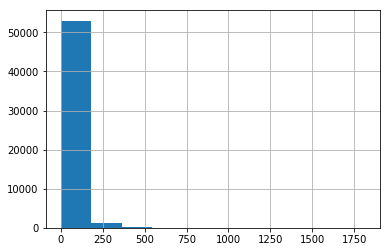

In [74]:
DataLengths.hist()

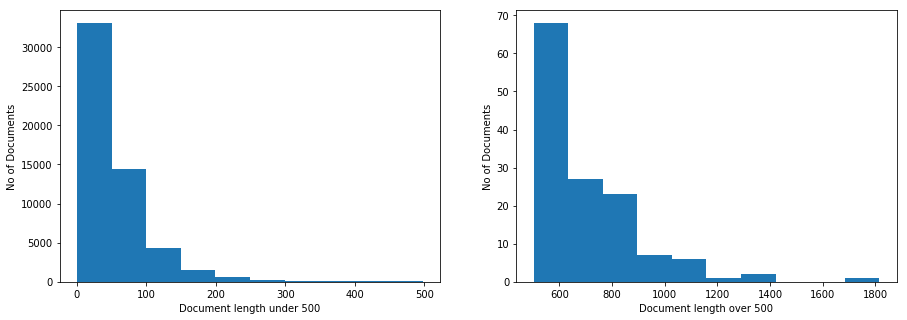

In [75]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(DataLengths[DataLengths <= 500]);
ax1.set_xlabel('Document length under 500')
ax1.set_ylabel('No of Documents')
ax2.hist(DataLengths[DataLengths > 500]);
ax2.set_xlabel('Document length over 500')
ax2.set_ylabel('No of Documents');

In [76]:
WordCounts = Text_df.WordCount

In [77]:
WordCounts.mean(), WordCounts.std(), WordCounts.min(), WordCounts.max()

(12.027097790065364, 11.817984106386616, 1, 365)

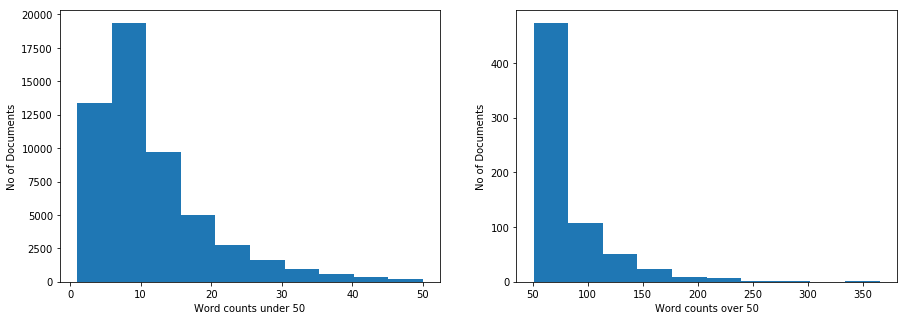

In [78]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(WordCounts[WordCounts <= 50]);
ax1.set_xlabel('Word counts under 50')
ax1.set_ylabel('No of Documents')
ax2.hist(WordCounts[WordCounts > 50]);
ax2.set_xlabel('Word counts over 50')
ax2.set_ylabel('No of Documents');

In [79]:
pd.set_option('display.max_colwidth', 80)

In [84]:
WordCountsClean = Text_df[~Text_df.index.isin(badRows)].WordCount

In [85]:
WordCountsClean.mean(), WordCountsClean.std(), WordCountsClean.min(), WordCountsClean.max()

(12.036820497782339, 11.819940124318654, 3, 365)

## Export as an alternative text file without the very short entries

In [86]:
import os
output_file = os.path.join('./data/Seinfeld_Scripts_cleaned.txt')
with open(output_file, 'w') as f:
    for txt in Text_df[~Text_df.index.isin(badRows)]["Text"].tolist():
        f.write(txt + '\n\n')

# Set up a word2vec lookup so we can use pre-trained weights later
- https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
- using the Glove 6B set

In [4]:
import os
glove_path = '../../data/glove6B'
glove_file = os.path.join(f'{glove_path}/glove.6B.300d.txt')
use_word2vec = (os.path.isfile(glove_file)) 
use_word2vec

True

In [5]:
use_word2vec and os.path.isfile(f'{glove_path}/6B.300_words.pkl')

True

In [6]:
import bcolz
import numpy as np
import pickle
if use_word2vec and not os.path.isfile(f'{glove_path}/6B.300_words.pkl'):
    w2v_words = []
    idx = 0
    w2v_word2idx = {}
    w2v_vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.300.dat', mode='w')

    with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            w2v_words.append(word)
            w2v_word2idx[word] = idx
            idx += 1
            vect = np.array(line[1:]).astype(np.float)
            w2v_vectors.append(vect)

    w2v_vectors = bcolz.carray(w2v_vectors[1:].reshape((400000, 300)), rootdir=f'{glove_path}/6B.300.dat', mode='w')
    w2v_vectors.flush()
    pickle.dump(w2v_words, open(f'{glove_path}/6B.300_words.pkl', 'wb'))
    pickle.dump(w2v_word2idx, open(f'{glove_path}/6B.300_idx.pkl', 'wb'))

In [5]:
import bcolz
import pickle
if use_word2vec:
    w2v_vectors = bcolz.open(f'{glove_path}/6B.300.dat')[:]
    w2v_words = pickle.load(open(f'{glove_path}/6B.300_words.pkl', 'rb'))
    w2v_word2idx = pickle.load(open(f'{glove_path}/6B.300_idx.pkl', 'rb'))

    glove = {w: w2v_vectors[w2v_word2idx[w]] for w in w2v_words}

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [4]:
from collections import Counter
import problem_unittests as tests

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement Function
    if type(text) == str:
        text = text.split()
    word_counts = Counter(text)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    
    return vocab_to_int, int_to_vocab    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [5]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    token_dict = {
        '.'   : '||period||',
        ','   : '||comma||',
        '"'   : '||quotation_mark||',
        ';'   : '||semi_colon||',
        '!'   : '||exclamation_mark||',
        '?'   : '||question_mark||',
        '('   : '||left_parentheses||',
        ')'   : '||right_parentheses||',
        '-'   : '||dash||',
        '\n'  : '||return||'
    }    
    
    return token_dict

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

## Creating my own version of the data so I can eliminiate the very short texts

In [6]:
import os
import pickle
import torch
import helper
import problem_unittests as tests

def preprocess_and_save_data_2(dataset_path, token_lookup, create_lookup_tables, picklefilename):
    """
    Preprocess Text Data
    """
    text = helper.load_data(dataset_path)
    
#     # Ignore notice, since we don't use it for analysing the data
#     text = text[81:]
# Don't see anything unusual in first 80 characters...

    token_dict = token_lookup()
    for key, token in token_dict.items():
        text = text.replace(key, ' {} '.format(token))

    text = text.lower()
    text = text.split()
    
    vocab_to_int, int_to_vocab = create_lookup_tables(text + list(helper.SPECIAL_WORDS.values()))
    int_text = [vocab_to_int[word] for word in text]
    pickle.dump((int_text, vocab_to_int, int_to_vocab, token_dict), open(picklefilename, 'wb'))
    
def load_preprocess_2(picklefilename):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open(picklefilename, mode='rb'))    

### Uses previously exported Seinfeld_Scripts_cleaned.txt

In [132]:
data_dir_cleaned = './data/Seinfeld_Scripts_cleaned.txt'
picklefilename = 'preprocess_clean.p'
preprocess_and_save_data_2(data_dir_cleaned, token_lookup, create_lookup_tables, picklefilename)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

### Alternatively, reload processed Seinfeld_Scripts_cleaned.txt

In [7]:
import helper
import problem_unittests as tests

picklefilename = 'preprocess_clean.p'
int_text, vocab_to_int, int_to_vocab, token_dict = load_preprocess_2(picklefilename)

In [44]:
int_text[:20]

[7, 34, 4, 27, 18, 24, 22, 50, 58, 3, 34, 4, 27, 2, 83, 120, 62, 3, 8, 54]

In [45]:
print([int_to_vocab[i] for i in int_text[:20]])

['jerry:', 'do', 'you', 'know', 'what', 'this', 'is', 'all', 'about', '||question_mark||', 'do', 'you', 'know', '||comma||', 'why', 'were', 'here', '||question_mark||', 'to', 'be']


In [134]:
len(int_text), len(vocab_to_int), len(int_to_vocab), len(token_dict)

(891811, 21380, 21380, 10)

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [9]:
device = torch.device("cuda" if train_on_gpu else "cpu")  

In [10]:
device

device(type='cuda')

In [50]:
torch.cuda.current_device()

0

In [51]:
torch.cuda.device_count()

1

In [52]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

### From Udacity knowledge base - Survesh C

## Adapted from Udacity knowledge base code ~ Survesh C

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def batch_data(words, sequence_length, batch_size, padbatch=False):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    
    # keep only enough words to make full sequences, so adjust to 5 from end
    dwords = words[:-sequence_length]
    arr_len = len(dwords)
    
    # if the adjusted length is greater than zero then process further, otherwise deal with it later
    if arr_len > 0:
        feature_tensors = []
        target_tensors = []

        # iterate through the array, one sequence at a time
        for n in range(0, len(dwords)):
            feature_tensors.append(words[n:n+sequence_length])
            target_tensors.append(words[n+sequence_length])
            
        # convert the arrays to numpy arrays before further processing
        feature_tensors = np.array(feature_tensors) 
        target_tensors = np.array(target_tensors)

        # get the number of whole batches
        num_batches = len(dwords)//batch_size
        
        # check total array size, for comparison with whole batch size
        arr_len = len(feature_tensors)

    # arrange for arrays to be padded with zeros to return whole batches...
    if (arr_len <= 0) or (arr_len < batch_size and padbatch==False):
        # nothing at all to process, just return all zeros - ignore padbatch setting
        feature_tensors = np.zeros((batch_size, sequence_length))
        target_tensors  = np.zeros(batch_size)
    elif arr_len < batch_size and padbatch==True:
        # the incoming data exists, but is not enough for one batch, pad the batch with zero
        feature_tensors = np.pad(feature_tensors, [(0, batch_size - arr_len), (0, 0)], mode='constant')
        target_tensors  = np.pad(target_tensors,  [(0, batch_size - arr_len)], mode='constant')        
    elif num_batches*batch_size < arr_len and padbatch==True:
        # when possible whole batches are removed we have a few record remaining, pad the last batch with zero
        feature_tensors = np.pad(feature_tensors, [(0, arr_len - num_batches*batch_size), (0, 0)], mode='constant')
        target_tensors  = np.pad(target_tensors,  [(0, arr_len - num_batches*batch_size)], mode='constant')
    else:
        # everything is balanced, not strictly required as we have all complete batches already
        feature_tensors = feature_tensors[:num_batches*batch_size]
        target_tensors = target_tensors[:num_batches*batch_size]
        
#     print(arr_len)
#     print(feature_tensors)
#     print(target_tensors)

    # convert to torch tensors
    torch_features = torch.from_numpy(feature_tensors).long()
    torch_targets = torch.from_numpy(target_tensors).long()
    
    # create a TensorDataset and then a DataLoader
    data = TensorDataset(torch_features, torch_targets)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return data_loader

### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [54]:
test_text = [15,16,17,18,19,20]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [15, 16, 17, 18, 19],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])

torch.Size([10])
tensor([ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0])


In [56]:
# test dataloader

test_text = range(156)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[127, 128, 129, 130, 131],
        [ 69,  70,  71,  72,  73],
        [102, 103, 104, 105, 106],
        [ 93,  94,  95,  96,  97],
        [ 77,  78,  79,  80,  81],
        [ 76,  77,  78,  79,  80],
        [123, 124, 125, 126, 127],
        [ 63,  64,  65,  66,  67],
        [ 73,  74,  75,  76,  77],
        [147, 148, 149, 150, 151]])

torch.Size([10])
tensor([132,  74, 107,  98,  82,  81, 128,  68,  78, 152])


### Test dataloader with padbatch=False (the default)
- maximum combination is `[39, 40, 41, 42, 43],[44]`

In [57]:
# test dataloader with padbatch=False (the default)

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=False)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[26, 27, 28, 29, 30],
        [20, 21, 22, 23, 24],
        [27, 28, 29, 30, 31],
        [36, 37, 38, 39, 40],
        [12, 13, 14, 15, 16],
        [11, 12, 13, 14, 15],
        [21, 22, 23, 24, 25],
        [28, 29, 30, 31, 32],
        [15, 16, 17, 18, 19],
        [35, 36, 37, 38, 39]])

torch.Size([10])
tensor([31, 25, 32, 41, 17, 16, 26, 33, 20, 40])


In [58]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[10, 11, 12, 13, 14],
        [38, 39, 40, 41, 42],
        [13, 14, 15, 16, 17],
        [ 0,  1,  2,  3,  4],
        [18, 19, 20, 21, 22],
        [29, 30, 31, 32, 33],
        [24, 25, 26, 27, 28],
        [22, 23, 24, 25, 26],
        [31, 32, 33, 34, 35],
        [14, 15, 16, 17, 18]])

torch.Size([10])
tensor([15, 43, 18,  5, 23, 34, 29, 27, 36, 19])


In [59]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 8,  9, 10, 11, 12],
        [ 6,  7,  8,  9, 10],
        [32, 33, 34, 35, 36],
        [30, 31, 32, 33, 34],
        [ 3,  4,  5,  6,  7],
        [ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6],
        [39, 40, 41, 42, 43],
        [34, 35, 36, 37, 38]])

torch.Size([10])
tensor([13, 11, 37, 35,  8,  6, 22,  7, 44, 39])


In [60]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 4,  5,  6,  7,  8],
        [25, 26, 27, 28, 29],
        [23, 24, 25, 26, 27],
        [ 9, 10, 11, 12, 13],
        [16, 17, 18, 19, 20],
        [ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23],
        [33, 34, 35, 36, 37],
        [37, 38, 39, 40, 41],
        [ 7,  8,  9, 10, 11]])

torch.Size([10])
tensor([ 9, 30, 28, 14, 21, 10, 24, 38, 42, 12])


In [61]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

StopIteration: 

> g:\anaconda3\lib\site-packages\torch\utils\data\dataloader.py(313)__next__()
    311     def __next__(self):
    312         if self.num_workers == 0:  # same-process loading
--> 313             indices = next(self.sample_iter)  # may raise StopIteration
    314             batch = self.collate_fn([self.dataset[i] for i in indices])
    315             if self.pin_memory:



### Test dataloader with padbatch=True
- maximum combination is `[44, 45, 46, 47, 48],[49]` which is the entire range

In [62]:
# test dataloader with padbatch=False (the default)

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32],
        [ 1,  2,  3,  4,  5],
        [38, 39, 40, 41, 42],
        [ 2,  3,  4,  5,  6],
        [ 0,  0,  0,  0,  0],
        [17, 18, 19, 20, 21],
        [32, 33, 34, 35, 36],
        [27, 28, 29, 30, 31],
        [ 9, 10, 11, 12, 13]], dtype=torch.int32)

torch.Size([10])
tensor([17, 33,  6, 43,  7,  0, 22, 37, 32, 14], dtype=torch.int32)


In [63]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 6,  7,  8,  9, 10],
        [34, 35, 36, 37, 38],
        [44, 45, 46, 47, 48],
        [30, 31, 32, 33, 34],
        [18, 19, 20, 21, 22],
        [16, 17, 18, 19, 20],
        [24, 25, 26, 27, 28],
        [42, 43, 44, 45, 46],
        [11, 12, 13, 14, 15],
        [35, 36, 37, 38, 39]], dtype=torch.int32)

torch.Size([10])
tensor([11, 39, 49, 35, 23, 21, 29, 47, 16, 40], dtype=torch.int32)


In [64]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[39, 40, 41, 42, 43],
        [26, 27, 28, 29, 30],
        [ 5,  6,  7,  8,  9],
        [21, 22, 23, 24, 25],
        [40, 41, 42, 43, 44],
        [ 0,  1,  2,  3,  4],
        [25, 26, 27, 28, 29],
        [14, 15, 16, 17, 18],
        [33, 34, 35, 36, 37],
        [29, 30, 31, 32, 33]], dtype=torch.int32)

torch.Size([10])
tensor([44, 31, 10, 26, 45,  5, 30, 19, 38, 34], dtype=torch.int32)


In [65]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[15, 16, 17, 18, 19],
        [ 0,  0,  0,  0,  0],
        [19, 20, 21, 22, 23],
        [13, 14, 15, 16, 17],
        [ 0,  0,  0,  0,  0],
        [31, 32, 33, 34, 35],
        [ 0,  0,  0,  0,  0],
        [ 7,  8,  9, 10, 11],
        [ 0,  0,  0,  0,  0],
        [22, 23, 24, 25, 26]], dtype=torch.int32)

torch.Size([10])
tensor([20,  0, 24, 18,  0, 36,  0, 12,  0, 27], dtype=torch.int32)


In [66]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[23, 24, 25, 26, 27],
        [37, 38, 39, 40, 41],
        [ 4,  5,  6,  7,  8],
        [41, 42, 43, 44, 45],
        [ 8,  9, 10, 11, 12],
        [36, 37, 38, 39, 40],
        [20, 21, 22, 23, 24],
        [43, 44, 45, 46, 47],
        [ 3,  4,  5,  6,  7],
        [10, 11, 12, 13, 14]], dtype=torch.int32)

torch.Size([10])
tensor([28, 42,  9, 46, 13, 41, 25, 48,  8, 15], dtype=torch.int32)


In [67]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

StopIteration: 

In [69]:
test_text = [15,16,17,18,19,25,26,27,28,29,35,36,37,38,39,45,46,47,48,49,55,56,57,58,59,65,66,67,68,69]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[36, 37, 38, 39, 45],
        [17, 18, 19, 25, 26],
        [27, 28, 29, 35, 36],
        [58, 59, 65, 66, 67],
        [18, 19, 25, 26, 27],
        [57, 58, 59, 65, 66],
        [ 0,  0,  0,  0,  0],
        [55, 56, 57, 58, 59],
        [56, 57, 58, 59, 65],
        [35, 36, 37, 38, 39]], dtype=torch.int32)

torch.Size([10])
tensor([46, 27, 37, 68, 28, 67,  0, 65, 66, 45], dtype=torch.int32)


In [70]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[47, 48, 49, 55, 56],
        [25, 26, 27, 28, 29],
        [28, 29, 35, 36, 37],
        [ 0,  0,  0,  0,  0],
        [38, 39, 45, 46, 47],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [15, 16, 17, 18, 19],
        [37, 38, 39, 45, 46],
        [45, 46, 47, 48, 49]], dtype=torch.int32)

torch.Size([10])
tensor([57, 35, 38,  0, 48,  0,  0, 25, 47, 55], dtype=torch.int32)


In [71]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[49, 55, 56, 57, 58],
        [29, 35, 36, 37, 38],
        [48, 49, 55, 56, 57],
        [ 0,  0,  0,  0,  0],
        [39, 45, 46, 47, 48],
        [19, 25, 26, 27, 28],
        [46, 47, 48, 49, 55],
        [59, 65, 66, 67, 68],
        [26, 27, 28, 29, 35],
        [16, 17, 18, 19, 25]], dtype=torch.int32)

torch.Size([10])
tensor([59, 39, 58,  0, 49, 29, 56, 69, 36, 26], dtype=torch.int32)


In [72]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

StopIteration: 

In [73]:
test_text = [15,16,17,18,19,25,26,27,28,29,35,36,37,38,39]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[28, 29, 35, 36, 37],
        [16, 17, 18, 19, 25],
        [19, 25, 26, 27, 28],
        [17, 18, 19, 25, 26],
        [29, 35, 36, 37, 38],
        [18, 19, 25, 26, 27],
        [27, 28, 29, 35, 36],
        [26, 27, 28, 29, 35],
        [25, 26, 27, 28, 29],
        [15, 16, 17, 18, 19]], dtype=torch.int32)

torch.Size([10])
tensor([38, 26, 29, 27, 39, 28, 37, 36, 35, 25], dtype=torch.int32)


In [74]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

StopIteration: 

In [75]:
test_text = [15,16,17,18,19,25,26,27,28,29,35,36,37,38]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[18, 19, 25, 26, 27],
        [28, 29, 35, 36, 37],
        [15, 16, 17, 18, 19],
        [25, 26, 27, 28, 29],
        [27, 28, 29, 35, 36],
        [17, 18, 19, 25, 26],
        [ 0,  0,  0,  0,  0],
        [16, 17, 18, 19, 25],
        [19, 25, 26, 27, 28],
        [26, 27, 28, 29, 35]], dtype=torch.int32)

torch.Size([10])
tensor([28, 38, 25, 35, 37, 27,  0, 26, 29, 36], dtype=torch.int32)


In [76]:
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

StopIteration: 

In [77]:
test_text = [15,16,17,18,19,20]
t_loader = batch_data(test_text, sequence_length=5, batch_size=10, padbatch=True)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [15, 16, 17, 18, 19],
        [ 0,  0,  0,  0,  0]], dtype=torch.int32)

torch.Size([10])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0], dtype=torch.int32)


---
## Load word2vec vectors into a weights array if applicable

In [18]:
weights_matrix = []
words_found = 0
emb_dim = 300

if use_word2vec:
    matrix_len = len(vocab_to_int)
    weights_matrix = np.zeros((matrix_len, emb_dim))

    for i, word in enumerate(vocab_to_int):
        try: 
            weights_matrix[i] = glove[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
            
len(weights_matrix), words_found    

### Save weights_matrix if needed

In [ ]:
pickle.dump(weights_matrix, open(f'weights_matrix.pkl', 'wb'))

### Load weights_matrix if needed

In [12]:
import pickle
if os.path.isfile(f'weights_matrix.pkl'):
    weights_matrix = pickle.load(open(f'weights_matrix.pkl', 'rb'))

In [13]:
weights_matrix = torch.FloatTensor(weights_matrix)

In [141]:
len(weights_matrix)

21380

In [26]:
len(weights_matrix[0])

300

---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [27]:
# Set/reset GPU
use_gpu=True
train_on_gpu = (use_gpu==True and torch.cuda.is_available())
device = torch.device("cuda" if train_on_gpu else "cpu")  
print(train_on_gpu)
device

True


device(type='cuda')

In [ ]:
del rnn

In [42]:
%%time

import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5, 
                 droplayer_dropout=0.3,
                 use_word2vec=True,
                 rnnType='LSTM'
                 # , weightDrop=0, tieWeights=False ## placeholder - might experiment with weight dropout, weight tieing
                 ):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        
        # TODO: Implement function
        
        # set class variables
        self.vocab_size = vocab_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_word2vec = use_word2vec
        self.rnnType = rnnType
        #self.rnnType='LSTM'
        
        # Set dropout layer to a separate value to passed dropout used by the LSTM 
        self.droplayer_dropout = droplayer_dropout # self.dropout # 0.3
        
        # define model layers
        
        # Embedding layer - use pre-trained word2vec if use_word2vec is True 
        # and we've been asked for a 300 dimension embedding
        if use_word2vec and self.embedding_dim==300:
            self.word_embeddings = nn.Embedding.from_pretrained(weights_matrix)
        else:    
            self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # use an LSTM or GRU
        if self.rnnType=='LSTM':
            self.rnn = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers,
                               dropout=self.dropout, batch_first=True) 
        else:
            self.rnn = nn.GRU(self.embedding_dim, self.hidden_dim, self.n_layers,
                              dropout=self.dropout, batch_first=True)
            
        # Dropout
        # self.dropout_layer = nn.Dropout(self.droplayer_dropout)
        
        # Output Linear layer
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """

        # TODO: Implement function 
        batch_size = nn_input.size(0)
        
        # get embeddings from input
        embeddings = self.word_embeddings(nn_input.long()) 

        # Get the outputs and the new hidden state from the lstm/gru
        output, hidden = self.rnn(embeddings, hidden)
        
        # Stack up outputs using view
        output = output.contiguous().view(-1, self.hidden_dim)
        
        # pass through dropout
        # removing this step as it is preventing model from converging...
        # output = self.dropout_layer(output)
        
        # push through the fully-connected layer
        output = self.fc(output)
        
        # reshape to batch size (first dimension of nn_input), sequence length, output size
        output = output.view(batch_size, -1, self.output_size)
        
        # get last batch
        out = output[:, -1]
        
        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data
        
        if self.rnnType=='LSTM':
            if (train_on_gpu):
                hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                          weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
            else:
                hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                          weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        else:
            if (train_on_gpu):
                hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            else:
                hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        
#         hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
#                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
    
        return hidden
       
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed
Wall time: 49.1 ms


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [16]:
# https://github.com/pytorch/examples/blob/master/word_language_model/main.py
# https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426
# "If we did not truncate the history of hidden states (c, h), the back-propagated gradients would flow from the loss 
#  towards the beginning, which may result in gradient vanishing or exploding." 
# https://github.com/pytorch/pytorch/issues/2198

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [17]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    if train_on_gpu:
        inp, target = inp.cuda(), target.cuda()
        
    # perform backpropagation and optimization
    
    # Truncated BPTT
    # [h.detach_() for h in hidden]
    hidden = repackage_hidden(hidden)
    
    # zeroize gradients
    rnn.zero_grad()
    
    # retrieve output of forward pass
    output, hidden = rnn(inp, hidden)
    
    # calaculate the loss 
    loss = criterion(output.squeeze(), target)
    
    # back propogation
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(), 10)
    
    # optimizer step
    optimizer.step()

    # return the loss value and hidden state
    return loss.item(), hidden    

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [18]:
train_losses = []
best_loss = 5

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    # C.Palmer - Added next 2 lines
    global best_loss
    curr_epoch = 1
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # C.Palmer - Added code block
        # Save per epoch
        if epoch_i > curr_epoch:
            save_model_name = 'gru_epoch_' + str(curr_epoch)
            helper.save_model(f'./save/{save_model_name}', rnn)
            curr_epoch = epoch_i
            
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # C.Palmer - Save losses for graphing and model if loss has improved
            train_losses.append(loss)
            
            # printing loss stats, saving best average loss
            if batch_i % show_every_n_batches == 0:
                avg_loss = np.average(batch_losses)
                print('Epoch: {:>4}/{:<4}  Loss: {}'.format(
                    epoch_i, n_epochs, avg_loss))
                batch_losses = []
                
                if avg_loss < best_loss:
                    save_model_name = 'gru_best_loss_' + str(epoch_i)
                    print('Validation loss decreased {:.6f} --> {:.6f}  (Saving model as {}...\n)'.format(
                          best_loss, avg_loss, save_model_name))
                    helper.save_model(f'./save/{save_model_name}', rnn)
                    best_loss = avg_loss
                else:
                    print()
                

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [20]:
# Data params
# Sequence Length
sequence_length = 8 # 10  # of words in a sequence
# Batch Size
batch_size = 100

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [21]:
# Training parameters
# Number of Epochs
num_epochs = 5
# Learning Rate
learning_rate = 0.0005

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int) # +1 for the 0 padding + our word tokens # 20000
# Output size
output_size = len(vocab_to_int) # 1000
# Embedding Dimension
embedding_dim = 300
# Hidden Dimension
hidden_dim = 300
# Number of RNN Layers
n_layers = 3

# Show stats for every n number of batches
show_every_n_batches = 500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [ ]:
"""`
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5, rnnType='GRU')
if train_on_gpu:
    rnn.cuda()

In [27]:
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [160]:
# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_gru', trained_rnn)
print('Model Trained and Saved')

Training for 5 epoch(s)...
Epoch:    1/5     Loss: 5.655953104019165

Epoch:    1/5     Loss: 4.920967402935028

Validation loss decreased (5.000000 --> 4.920967  Saving model as gru_best_loss_1...)


G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    1/5     Loss: 4.698572873115539

Validation loss decreased (4.920967 --> 4.698573  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.599360318660736

Validation loss decreased (4.698573 --> 4.599360  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.5112484817504885

Validation loss decreased (4.599360 --> 4.511248  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.450126693725586

Validation loss decreased (4.511248 --> 4.450127  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.442722723007202

Validation loss decreased (4.450127 --> 4.442723  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.4102017669677736

Validation loss decreased (4.442723 --> 4.410202  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.358013504505157

Validation loss decreased (4.410202 --> 4.358014  Saving model as gru_best_loss_1...)
Epoch:    1/5     Loss: 4.352012413978577

Validation loss decreased (4.358014 --> 4.352012  Sa

In [28]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/gru_best_loss_5.pt')
trained_rnn = rnn

In [29]:
# Train for another 5 epochs

# Decrease learning rate
learning_rate  = 0.00008
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

trained_rnn_1 = train_rnn(trained_rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_gru_1', trained_rnn_1)
print('Model Trained and Saved')


Training for 5 epoch(s)...


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Epoch:    1/5     Loss: 3.7189364948272705
Validation loss decreased 5.000000 --> 3.718936  (Saving model as gru_best_loss_1...
)


G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    1/5     Loss: 3.7400720801353455

Epoch:    1/5     Loss: 3.7510755939483644

Epoch:    1/5     Loss: 3.73793487739563

Epoch:    1/5     Loss: 3.772494127750397

Epoch:    1/5     Loss: 3.754640988826752

Epoch:    1/5     Loss: 3.7412011098861693

Epoch:    1/5     Loss: 3.747421988964081

Epoch:    1/5     Loss: 3.7559402117729186

Epoch:    1/5     Loss: 3.7577231106758116

Epoch:    1/5     Loss: 3.7580474600791933

Epoch:    1/5     Loss: 3.760154052734375

Epoch:    1/5     Loss: 3.7641247668266296

Epoch:    1/5     Loss: 3.705044276714325
Validation loss decreased 3.718936 --> 3.705044  (Saving model as gru_best_loss_1...
)
Epoch:    1/5     Loss: 3.7571734232902525

Epoch:    1/5     Loss: 3.7451093435287475

Epoch:    1/5     Loss: 3.7435311388969423

Epoch:    2/5     Loss: 3.727353930733043

Epoch:    2/5     Loss: 3.677408587932587
Validation loss decreased 3.705044 --> 3.677409  (Saving model as gru_best_loss_2...
)
Epoch:    2/5     Loss: 3.671142939567566
Val

In [35]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/trained_gru_1.pt')
trained_rnn_1 = rnn

In [36]:
# Train for another 5 epochs
batch_size = 120

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

# Increase learning rate
learning_rate  = 0.00005
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

trained_rnn_2 = train_rnn(trained_rnn_1, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_gru_2', trained_rnn_2)
print('Model Trained and Saved')


Training for 5 epoch(s)...


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Epoch:    1/5     Loss: 3.562190770149231

Epoch:    1/5     Loss: 3.6218850059509275

Epoch:    1/5     Loss: 3.6243217911720276

Epoch:    1/5     Loss: 3.62903919506073

Epoch:    1/5     Loss: 3.6646791000366212

Epoch:    1/5     Loss: 3.665488532066345

Epoch:    1/5     Loss: 3.6448135504722594

Epoch:    1/5     Loss: 3.6696839928627014

Epoch:    1/5     Loss: 3.6630232138633727

Epoch:    1/5     Loss: 3.6460369181632997

Epoch:    1/5     Loss: 3.666372320652008

Epoch:    1/5     Loss: 3.6398816623687744

Epoch:    1/5     Loss: 3.653681743144989

Epoch:    1/5     Loss: 3.6660710349082946



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    2/5     Loss: 3.629576656411209

Epoch:    2/5     Loss: 3.608115044116974

Epoch:    2/5     Loss: 3.6270658259391784

Epoch:    2/5     Loss: 3.599223853588104

Epoch:    2/5     Loss: 3.6087452416419983

Epoch:    2/5     Loss: 3.621360326766968

Epoch:    2/5     Loss: 3.5966427545547486

Epoch:    2/5     Loss: 3.6166015529632567

Epoch:    2/5     Loss: 3.6027181334495544

Epoch:    2/5     Loss: 3.6114007511138917

Epoch:    2/5     Loss: 3.619886267185211

Epoch:    2/5     Loss: 3.6309627299308778

Epoch:    2/5     Loss: 3.6210895080566408

Epoch:    2/5     Loss: 3.626650544166565

Epoch:    3/5     Loss: 3.599752081195983

Epoch:    3/5     Loss: 3.5881175270080568

Epoch:    3/5     Loss: 3.5849981732368468

Epoch:    3/5     Loss: 3.5800030298233034

Epoch:    3/5     Loss: 3.588196454048157

Epoch:    3/5     Loss: 3.5981535897254946

Epoch:    3/5     Loss: 3.5914709858894347

Epoch:    3/5     Loss: 3.5975018620491026

Epoch:    3/5     Loss: 3.58548953199386

In [35]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/gru_best_loss_5.pt')
trained_rnn_2 = rnn

In [37]:
# Train for another 10 epochs
num_epochs = 10

batch_size = 100
train_loader = batch_data(int_text, sequence_length, batch_size)

# Increase learning rate
learning_rate  = 0.0001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

trained_rnn_3 = train_rnn(trained_rnn_2, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_gru_3', trained_rnn_2)
print('Model Trained and Saved')


Training for 10 epoch(s)...


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Epoch:    1/10    Loss: 3.5919265990257263

Epoch:    1/10    Loss: 3.6313661856651307

Epoch:    1/10    Loss: 3.637884382247925

Epoch:    1/10    Loss: 3.6473238892555235

Epoch:    1/10    Loss: 3.6393966369628905

Epoch:    1/10    Loss: 3.6626023201942446

Epoch:    1/10    Loss: 3.663499396800995

Epoch:    1/10    Loss: 3.6782157135009768

Epoch:    1/10    Loss: 3.6655242586135866

Epoch:    1/10    Loss: 3.709804928779602

Epoch:    1/10    Loss: 3.672107084274292

Epoch:    1/10    Loss: 3.6583959488868714

Epoch:    1/10    Loss: 3.665170474052429

Epoch:    1/10    Loss: 3.6756955671310423

Epoch:    1/10    Loss: 3.6919367909431458

Epoch:    1/10    Loss: 3.66911225938797

Epoch:    1/10    Loss: 3.6663264536857607



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    2/10    Loss: 3.636653719644401

Epoch:    2/10    Loss: 3.6064183707237243

Epoch:    2/10    Loss: 3.604205942630768

Epoch:    2/10    Loss: 3.6057436604499817

Epoch:    2/10    Loss: 3.597622941493988

Epoch:    2/10    Loss: 3.617230119228363

Epoch:    2/10    Loss: 3.616527545928955

Epoch:    2/10    Loss: 3.637764232635498

Epoch:    2/10    Loss: 3.6041112122535703

Epoch:    2/10    Loss: 3.611369547367096

Epoch:    2/10    Loss: 3.609488865852356

Epoch:    2/10    Loss: 3.6038744292259217

Epoch:    2/10    Loss: 3.6135136275291444

Epoch:    2/10    Loss: 3.6009589982032777

Epoch:    2/10    Loss: 3.610627734184265

Epoch:    2/10    Loss: 3.6105760955810546

Epoch:    2/10    Loss: 3.626537703990936

Epoch:    3/10    Loss: 3.5999660598426604

Epoch:    3/10    Loss: 3.5789440698623656

Epoch:    3/10    Loss: 3.5655579385757448

Epoch:    3/10    Loss: 3.5609254870414735

Epoch:    3/10    Loss: 3.5601817574501036

Epoch:    3/10    Loss: 3.566032870769501


In [38]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/gru_best_loss_10.pt')


In [39]:
import warnings
warnings.simplefilter('ignore') # "error", "ignore", "always", "default", "module", or "once"

In [39]:
best_loss

5

In [43]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/rnn_epoch_2.pt')

In [36]:
train_losses = []
best_loss = 4

In [ ]:
"""`
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 5 epoch(s)...
Epoch:    1/5     Loss: 5.944227313041687

Validation loss decreased (4.000000 --> 3.954424  Saving model as rnn_best_loss_1...)


G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:    1/5     Loss: 5.244075174808502

Epoch:    1/5     Loss: 5.0523648281097415

Epoch:    1/5     Loss: 4.906247211456299

Validation loss decreased (3.954424 --> 3.728602  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 4.822373070716858

Epoch:    1/5     Loss: 4.715235330581665

Epoch:    1/5     Loss: 4.672761786460876

Validation loss decreased (3.728602 --> 3.596078  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 4.5987534003257755

Epoch:    1/5     Loss: 4.551686301708221

Epoch:    1/5     Loss: 4.534244474411011

Validation loss decreased (3.596078 --> 3.528541  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 4.517340178489685

Epoch:    1/5     Loss: 4.441306675434112

Validation loss decreased (3.528541 --> 3.448461  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 4.422550281524658

Validation loss decreased (3.448461 --> 3.436882  Saving model as rnn_best_loss_1...)
Epoch:    1/5     Loss: 4.416106160640717

Epoch:   

In [44]:
# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 2 epoch(s)...
Epoch:    1/2     Loss: 5.865503774642944

Epoch:    1/2     Loss: 5.176518495559693

Epoch:    1/2     Loss: 4.996342551231384

Epoch:    1/2     Loss: 4.84929174041748

Epoch:    1/2     Loss: 4.762707571506501

Epoch:    1/2     Loss: 4.711907629013061

Epoch:    1/2     Loss: 4.6595908284187315

Epoch:    1/2     Loss: 4.647165615558624

Epoch:    1/2     Loss: 4.550111070156097

Epoch:    1/2     Loss: 4.533562190055847

Epoch:    1/2     Loss: 4.4841990885734555

Validation loss decreased (4.000000 --> 3.935091  Saving model as rnn_best_loss_1...)
Epoch:    1/2     Loss: 4.47667335319519

Epoch:    1/2     Loss: 4.442802852153778

Epoch:    1/2     Loss: 4.399065585136413

Epoch:    1/2     Loss: 4.3737395148277285

Epoch:    1/2     Loss: 4.357177507400513

Epoch:    1/2     Loss: 4.346064671039581

Validation loss decreased (3.935091 --> 3.516610  Saving model as rnn_best_loss_1...)
Epoch:    2/2     Loss: 4.259999241370822

Epoch:    2/2     Loss: 4.

In [46]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 2
# Learning Rate
# learning_rate = 0.0005 # 0.001
# optimizer = torch.optim.Adam(trained_rnn.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn.cuda()

# continue training
trained_rnn_pt1 = train_rnn(trained_rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_1', trained_rnn_pt1)
print('Model Part 1 Trained and Saved')

Training for 2 epoch(s)...
Epoch:    1/2     Loss: 3.956729757785797

Epoch:    1/2     Loss: 3.9556993894577026

Epoch:    1/2     Loss: 3.9645977392196654

Epoch:    1/2     Loss: 3.9619477229118347

Epoch:    1/2     Loss: 3.955435347557068

Epoch:    1/2     Loss: 3.960486608028412

Epoch:    1/2     Loss: 3.9396376352310183

Epoch:    1/2     Loss: 3.906117203235626

Epoch:    1/2     Loss: 3.9412336740493776

Epoch:    1/2     Loss: 3.9517433185577393

Epoch:    1/2     Loss: 3.9297676548957825

Epoch:    1/2     Loss: 3.9519890189170837

Epoch:    1/2     Loss: 3.9478353395462036

Epoch:    1/2     Loss: 3.9589814229011537

Epoch:    1/2     Loss: 3.9453414602279664

Epoch:    1/2     Loss: 3.935541763305664

Epoch:    1/2     Loss: 3.9399028296470644

Epoch:    2/2     Loss: 3.8757789580061965

Epoch:    2/2     Loss: 3.8296719551086427

Epoch:    2/2     Loss: 3.8151361393928527

Epoch:    2/2     Loss: 3.7902107305526735

Epoch:    2/2     Loss: 3.820670301437378

Epoch:    2

In [48]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 2
# Learning Rate
learning_rate = 0.0001
optimizer = torch.optim.Adam(trained_rnn.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt1.cuda()

# continue training
trained_rnn_pt2 = train_rnn(trained_rnn_pt1, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_2', trained_rnn_pt2)
print('Model Part 2 Trained and Saved')

Training for 2 epoch(s)...
Epoch:    1/2     Loss: 3.505185773849487

Epoch:    1/2     Loss: 3.5116154127120973

Epoch:    1/2     Loss: 3.5259523935317993

Epoch:    1/2     Loss: 3.5403903493881224

Epoch:    1/2     Loss: 3.543002068042755

Epoch:    1/2     Loss: 3.5474021205902098

Epoch:    1/2     Loss: 3.574580738544464

Epoch:    1/2     Loss: 3.5552494773864747

Epoch:    1/2     Loss: 3.569469111442566

Epoch:    1/2     Loss: 3.5709846019744873

Epoch:    1/2     Loss: 3.5816702127456663

Epoch:    1/2     Loss: 3.5866164412498476

Epoch:    1/2     Loss: 3.5883570699691774

Epoch:    1/2     Loss: 3.5716041741371156

Epoch:    1/2     Loss: 3.580797835826874

Epoch:    1/2     Loss: 3.5760939373970033

Epoch:    1/2     Loss: 3.6014312934875488

Epoch:    2/2     Loss: 3.5483235235297523

Epoch:    2/2     Loss: 3.5115902132987977

Epoch:    2/2     Loss: 3.503722285270691

Epoch:    2/2     Loss: 3.5176263127326965

Epoch:    2/2     Loss: 3.5185277342796324

Epoch:    2

In [49]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 2
# Learning Rate
learning_rate = 0.00005
optimizer = torch.optim.Adam(trained_rnn_pt2.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt2.cuda()

# continue training
trained_rnn_pt3 = train_rnn(trained_rnn_pt2, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_3', trained_rnn_pt3)
print('Model Part 3 Trained and Saved')

Training for 2 epoch(s)...
Epoch:    1/2     Loss: 3.473530782699585

Validation loss decreased (3.477055 --> 3.473531  Saving model as rnn_best_loss_1...)
Epoch:    1/2     Loss: 3.514318596839905

Epoch:    1/2     Loss: 3.498549780368805

Epoch:    1/2     Loss: 3.506586533546448

Epoch:    1/2     Loss: 3.513839068889618

Epoch:    1/2     Loss: 3.5207704305648804

Epoch:    1/2     Loss: 3.524600082397461

Epoch:    1/2     Loss: 3.517486385345459

Epoch:    1/2     Loss: 3.5265615453720094

Epoch:    1/2     Loss: 3.5193706212043763

Epoch:    1/2     Loss: 3.5290869879722595

Epoch:    1/2     Loss: 3.52484258556366

Epoch:    1/2     Loss: 3.534989926815033

Epoch:    1/2     Loss: 3.5162753925323487

Epoch:    1/2     Loss: 3.544829180717468

Epoch:    1/2     Loss: 3.5366418786048888

Epoch:    1/2     Loss: 3.535442258358002

Epoch:    2/2     Loss: 3.498420618507019

Epoch:    2/2     Loss: 3.4927247018814085

Epoch:    2/2     Loss: 3.5095887212753296

Epoch:    2/2     Lo

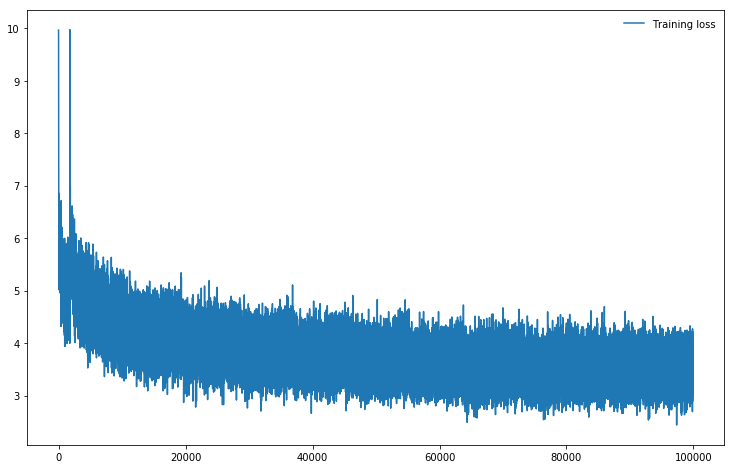

In [53]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [12.5, 8]

plt.plot(train_losses, label="Training loss")
plt.legend(frameon=False)
plt.show()

In [56]:
len(train_losses)

99864

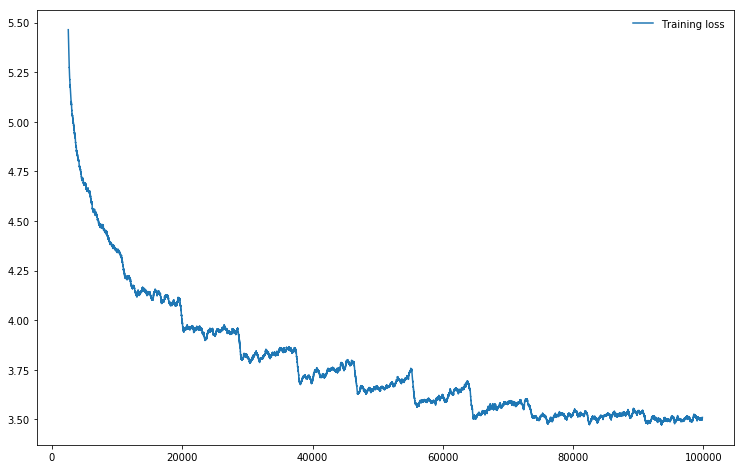

In [82]:
import pandas as pd
df_train_losses = pd.DataFrame(train_losses)

plt.plot(df_train_losses.rolling(window=500).mean()[2500:], label="Training loss")
plt.legend(frameon=False)
plt.show()

In [88]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn_pt3 = helper.load_model('./save/trained_300dim_10seq_rnn_3.pt')

In [89]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
learning_rate = 0.00001
optimizer = torch.optim.Adam(trained_rnn_pt3.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt3.cuda()

# continue training
trained_rnn_pt4 = train_rnn(trained_rnn_pt3, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_4', trained_rnn_pt4)
print('Model Part 4 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.4605517997741697

Validation loss decreased (3.473531 --> 3.460552  Saving model as rnn_best_loss_1...)
Epoch:    1/1     Loss: 3.4878827147483826

Epoch:    1/1     Loss: 3.4891793546676637

Epoch:    1/1     Loss: 3.4767498364448546

Epoch:    1/1     Loss: 3.486082179069519

Epoch:    1/1     Loss: 3.4952111678123474

Epoch:    1/1     Loss: 3.47319455909729

Epoch:    1/1     Loss: 3.4995745458602907

Epoch:    1/1     Loss: 3.4728086404800416

Epoch:    1/1     Loss: 3.493797983169556

Epoch:    1/1     Loss: 3.457060523033142

Validation loss decreased (3.460552 --> 3.457061  Saving model as rnn_best_loss_1...)
Epoch:    1/1     Loss: 3.4877461848258973

Epoch:    1/1     Loss: 3.482723305225372

Epoch:    1/1     Loss: 3.4955073676109314

Epoch:    1/1     Loss: 3.5259513006210326

Epoch:    1/1     Loss: 3.478898156642914

Epoch:    1/1     Loss: 3.4788305792808534

Model Part 4 Trained and Saved


In [90]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 2
# Learning Rate
learning_rate = 0.00001
optimizer = torch.optim.Adam(trained_rnn_pt4.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt4.cuda()

# continue training
trained_rnn_pt5 = train_rnn(trained_rnn_pt4, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_5', trained_rnn_pt5)
print('Model Part 5 Trained and Saved')

Training for 2 epoch(s)...
Epoch:    1/2     Loss: 3.46982736492157

Epoch:    1/2     Loss: 3.479756728172302

Epoch:    1/2     Loss: 3.4958036370277403

Epoch:    1/2     Loss: 3.486446915626526

Epoch:    1/2     Loss: 3.4859656138420103

Epoch:    1/2     Loss: 3.4742407007217406

Epoch:    1/2     Loss: 3.495132833480835

Epoch:    1/2     Loss: 3.47544793844223

Epoch:    1/2     Loss: 3.4963893580436705

Epoch:    1/2     Loss: 3.506485411167145

Epoch:    1/2     Loss: 3.49666242313385

Epoch:    1/2     Loss: 3.4824556012153627

Epoch:    1/2     Loss: 3.4750510563850403

Epoch:    1/2     Loss: 3.5118341150283814

Epoch:    1/2     Loss: 3.47335337972641

Epoch:    1/2     Loss: 3.4916643013954163

Epoch:    1/2     Loss: 3.5003785586357115

Epoch:    2/2     Loss: 3.502282022128459

Epoch:    2/2     Loss: 3.4752554512023925

Epoch:    2/2     Loss: 3.478547601699829

Epoch:    2/2     Loss: 3.493910975933075

Epoch:    2/2     Loss: 3.4824542264938354

Epoch:    2/2     Lo

In [47]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 3
# Learning Rate
# learning_rate = 0.0005 # 0.001
# optimizer = torch.optim.Adam(trained_rnn.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt1.cuda()

# continue training
trained_rnn_pt2 = train_rnn(trained_rnn_pt1, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_300dim_10seq_rnn_2', trained_rnn_pt2)
print('Model Part 2 Trained and Saved')

Training for 3 epoch(s)...
Epoch:    1/3     Loss: 3.694419502735138

Epoch:    1/3     Loss: 3.70517870759964

Epoch:    1/3     Loss: 3.70907510471344

Epoch:    1/3     Loss: 3.71585068321228

Epoch:    1/3     Loss: 3.6965926342010498

Epoch:    1/3     Loss: 3.7463539366722105

Epoch:    1/3     Loss: 3.7380347685813904

Epoch:    1/3     Loss: 3.7166589336395264

Epoch:    1/3     Loss: 3.7197377276420593

Epoch:    1/3     Loss: 3.7460652022361756

Epoch:    1/3     Loss: 3.759127670764923

Epoch:    1/3     Loss: 3.7433452644348146

Epoch:    1/3     Loss: 3.745898681640625

Epoch:    1/3     Loss: 3.7852863845825193

Epoch:    1/3     Loss: 3.75479070520401

Epoch:    1/3     Loss: 3.7968965339660645

Epoch:    1/3     Loss: 3.777852783679962

Epoch:    2/3     Loss: 3.7048563283083222

Epoch:    2/3     Loss: 3.6570533237457274

Epoch:    2/3     Loss: 3.6471484327316284

Epoch:    2/3     Loss: 3.6416601190567017

Epoch:    2/3     Loss: 3.6466299204826353

Epoch:    2/3    

In [ ]:
warnings.simplefilter('default') # "error", "ignore", "always", "default", "module", or "once"

In [29]:
# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Reloading previously saved model to rnn and its current variation
- run as required after setting correct variables

In [30]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
rnn = helper.load_model('./save/trained_rnn_pt3')
trained_rnn_pt3 = rnn

In [22]:
# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 5.972064340591431

Epoch:    1/1     Loss: 5.369360053062439

Epoch:    1/1     Loss: 5.021021647453308

Epoch:    1/1     Loss: 4.885162146568298

Epoch:    1/1     Loss: 4.752153550624848

Epoch:    1/1     Loss: 4.674219629764557

Epoch:    1/1     Loss: 4.634469316005707

Epoch:    1/1     Loss: 4.587717729568482

Epoch:    1/1     Loss: 4.545648058891296

Epoch:    1/1     Loss: 4.475488470554351

Epoch:    1/1     Loss: 4.459368526935577

Epoch:    1/1     Loss: 4.448844861507416

Epoch:    1/1     Loss: 4.406930876255036

Epoch:    1/1     Loss: 4.364120943069458

Epoch:    1/1     Loss: 4.364718734741211

Epoch:    1/1     Loss: 4.343876718044281

Epoch:    1/1     Loss: 4.361159281253815



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model BaseRNN Trained and Saved


In [22]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
learning_rate = 0.0005 # 0.001
optimizer = torch.optim.Adam(trained_rnn.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn.cuda()

# continue training
trained_rnn_pt1 = train_rnn(trained_rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt1', trained_rnn_pt1)
print('Model Part 1 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 4.231522994995117

Epoch:    1/1     Loss: 4.253600597381592

Epoch:    1/1     Loss: 4.2576593728065495

Epoch:    1/1     Loss: 4.275327283382416

Epoch:    1/1     Loss: 4.249647035121917

Epoch:    1/1     Loss: 4.259503119945526

Epoch:    1/1     Loss: 4.259066385269165

Epoch:    1/1     Loss: 4.2518379349708555

Epoch:    1/1     Loss: 4.206845601558685

Epoch:    1/1     Loss: 4.252801977157593

Epoch:    1/1     Loss: 4.218412055492401

Epoch:    1/1     Loss: 4.23741194820404

Epoch:    1/1     Loss: 4.210707931995392

Epoch:    1/1     Loss: 4.180311105251312

Epoch:    1/1     Loss: 4.197082179069519

Epoch:    1/1     Loss: 4.2100426254272465

Epoch:    1/1     Loss: 4.1941789193153385



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model BaseRNN Part 1 Trained and Saved


In [22]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
learning_rate = 0.0005 #  0.0005
optimizer = torch.optim.Adam(trained_rnn_pt1.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt1.cuda()

# continue training
trained_rnn_pt2 = train_rnn(trained_rnn_pt1, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt2', trained_rnn_pt2)
print('Model Part 2 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 4.072349384307861

Epoch:    1/1     Loss: 4.123880141735077

Epoch:    1/1     Loss: 4.173166821479797

Epoch:    1/1     Loss: 4.175968566894531

Epoch:    1/1     Loss: 4.179376143455506

Epoch:    1/1     Loss: 4.1614810280799865

Epoch:    1/1     Loss: 4.148808194637299

Epoch:    1/1     Loss: 4.146528200149536

Epoch:    1/1     Loss: 4.122422632217408

Epoch:    1/1     Loss: 4.160207946300506

Epoch:    1/1     Loss: 4.125617665290832

Epoch:    1/1     Loss: 4.154412338256836

Epoch:    1/1     Loss: 4.11604423713684

Epoch:    1/1     Loss: 4.1174641132354735

Epoch:    1/1     Loss: 4.134657438278198

Epoch:    1/1     Loss: 4.119311476230622

Epoch:    1/1     Loss: 4.121693664073944



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model BaseRNN Part 2 Trained and Saved


In [23]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
learning_rate = 0.0001
optimizer = torch.optim.Adam(trained_rnn_pt2.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt2.cuda()

# continue training
trained_rnn_pt3 = train_rnn(trained_rnn_pt2, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt3', trained_rnn_pt3)
print('Model Part 3 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.9990544881820678

Epoch:    1/1     Loss: 4.003589000701904

Epoch:    1/1     Loss: 4.014412614822388

Epoch:    1/1     Loss: 4.007320472717285

Epoch:    1/1     Loss: 4.027467278957367

Epoch:    1/1     Loss: 4.028640185832978

Epoch:    1/1     Loss: 4.024634702205658

Epoch:    1/1     Loss: 4.02352743434906

Epoch:    1/1     Loss: 4.0383592195510865

Epoch:    1/1     Loss: 4.021864737510681

Epoch:    1/1     Loss: 4.025226735591889

Epoch:    1/1     Loss: 4.034468657016754

Epoch:    1/1     Loss: 4.027440028190613

Epoch:    1/1     Loss: 4.025802571773529

Epoch:    1/1     Loss: 4.0179708743095395

Epoch:    1/1     Loss: 4.015987987041473

Epoch:    1/1     Loss: 4.020177857875824



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model BaseRNN Part 3 Trained and Saved


In [ ]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
learning_rate = 0.00005
optimizer = torch.optim.Adam(trained_rnn_pt3.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt3.cuda()

# continue training
trained_rnn_pt4 = train_rnn(trained_rnn_pt3, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt4', trained_rnn_pt4)
print('Model Part 4 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 4.036959685325622

Epoch:    1/1     Loss: 4.017330627441407



In [37]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
# learning_rate = 0.001 # 0.01
# optimizer = torch.optim.Adam(trained_rnn_pt4.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt4.cuda()

# continue training
trained_rnn_pt5 = train_rnn(trained_rnn_pt4, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt5', trained_rnn_pt5)
print('Model Part 5 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.7183467478752137

Epoch:    1/1     Loss: 3.730638340473175

Epoch:    1/1     Loss: 3.7145831031799315

Epoch:    1/1     Loss: 3.709007933139801

Epoch:    1/1     Loss: 3.7331894302368163

Epoch:    1/1     Loss: 3.718268032550812

Epoch:    1/1     Loss: 3.7419456129074096

Epoch:    1/1     Loss: 3.742920315742493

Epoch:    1/1     Loss: 3.7547633991241454

Epoch:    1/1     Loss: 3.7627038922309874

Epoch:    1/1     Loss: 3.7667068881988524

Epoch:    1/1     Loss: 3.7586594967842104

Epoch:    1/1     Loss: 3.7911146421432496

Epoch:    1/1     Loss: 3.7794602127075194

Epoch:    1/1     Loss: 3.7846356081962584

Epoch:    1/1     Loss: 3.770748375892639

Epoch:    1/1     Loss: 3.8044521660804747



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model Part 5 Trained and Saved


In [38]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
# learning_rate = 0.001 # 0.01
# optimizer = torch.optim.Adam(trained_rnn_pt5.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt5.cuda()

# continue training
trained_rnn_pt6 = train_rnn(trained_rnn_pt5, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt6', trained_rnn_pt6)
print('Model Part 6 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.6556635670661928

Epoch:    1/1     Loss: 3.6724784035682676

Epoch:    1/1     Loss: 3.665190236568451

Epoch:    1/1     Loss: 3.6764680981636046

Epoch:    1/1     Loss: 3.7050700402259826

Epoch:    1/1     Loss: 3.681219947814941

Epoch:    1/1     Loss: 3.667770323753357

Epoch:    1/1     Loss: 3.696846963405609

Epoch:    1/1     Loss: 3.7072008147239686

Epoch:    1/1     Loss: 3.7325415291786195

Epoch:    1/1     Loss: 3.7091239657402038

Epoch:    1/1     Loss: 3.749235827922821

Epoch:    1/1     Loss: 3.740165548324585

Epoch:    1/1     Loss: 3.730985441684723

Epoch:    1/1     Loss: 3.7617514119148256

Epoch:    1/1     Loss: 3.7492493200302124

Epoch:    1/1     Loss: 3.750619017601013



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model Part 6 Trained and Saved


In [52]:
_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn_pt6 = helper.load_model('./save/trained_rnn_pt6')

In [53]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
# learning_rate = 0.0005 # 0.01
# optimizer = torch.optim.Adam(trained_rnn_pt6.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt6.cuda()

# continue training
trained_rnn_pt7 = train_rnn(trained_rnn_pt6, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt7', trained_rnn_pt7)
print('Model Part 7 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.623252453804016

Epoch:    1/1     Loss: 3.6106294975280764

Epoch:    1/1     Loss: 3.643563732147217

Epoch:    1/1     Loss: 3.641532206058502

Epoch:    1/1     Loss: 3.633232105731964

Epoch:    1/1     Loss: 3.6461421823501587

Epoch:    1/1     Loss: 3.6248095746040345

Epoch:    1/1     Loss: 3.624413591861725

Epoch:    1/1     Loss: 3.6318763689994813

Epoch:    1/1     Loss: 3.629365211009979

Epoch:    1/1     Loss: 3.622381470680237

Epoch:    1/1     Loss: 3.6109280681610105

Epoch:    1/1     Loss: 3.636050974369049

Epoch:    1/1     Loss: 3.624892519950867

Epoch:    1/1     Loss: 3.6370719633102415

Epoch:    1/1     Loss: 3.6563348703384397

Epoch:    1/1     Loss: 3.6114463849067686



G:\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model Part 7 Trained and Saved


In [ ]:
# to carry on training with same model....
# after each run, increment name of target (and therefore saved) model,
# when re-running again use the previous saved model as the one being further trained...
num_epochs = 1
# Learning Rate
# learning_rate = 0.0005 # 0.01
# optimizer = torch.optim.Adam(trained_rnn_pt7.parameters(), lr=learning_rate)

if train_on_gpu:
    trained_rnn_pt7.cuda()

# continue training
trained_rnn_pt8 = train_rnn(trained_rnn_pt7, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn_pt8', trained_rnn_pt8)
print('Model Part 8 Trained and Saved')

Training for 1 epoch(s)...
Epoch:    1/1     Loss: 3.6163598260879515

Epoch:    1/1     Loss: 3.643967906951904

Epoch:    1/1     Loss: 3.619757791996002

Epoch:    1/1     Loss: 3.6200353078842165

Epoch:    1/1     Loss: 3.641231981754303

Epoch:    1/1     Loss: 3.618289442539215

Epoch:    1/1     Loss: 3.648731572151184

Epoch:    1/1     Loss: 3.6240380001068115



### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** (Write answer, here)

---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnn')

In [91]:
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_300dim_10seq_rnn_4')

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [40]:
# run the cell multiple times to get different results!
gen_length = 500 # modify the length to your preference
prime_word = 'kramer' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


kramer: to see him.

jerry: i know what i think.

jerry: i mean what if i don't like to see you?

george: i got to get it in there, i don't know what to do.

george:(to himself) what is this?

kramer:(smiling) well, i guess it's gonna go out with him, i just wanted to get the hell back.

george: what do you think?

jerry:(to elaine) i have a little thing for you.

jerry:(to jerry) you should have been a good time for you.

elaine: i can't do it...

elaine: i don't know what you think.

elaine: well, you know how you feel like that?

jerry: i don't like the bathroom.

george: what is that?

kramer: oh, well, i just don't think we can be a problem.

jerry: i think i have to go with a little more time.(they both look at her.

elaine: well, i was thinking about this, but i don't know what i do.

jerry: what?!?

george: i don't know.

jerry: well, you want to be the one who has to do.

kramer: yeah, well, i think it's something...

george: well, i don't think so.

george:(looking at george)

In [99]:
# run the cell multiple times to get different results!
gen_length = 500 # modify the length to your preference
prime_word = 'kramer' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

kramer:

elaine:(to george) what do you mean...(turns to elaine) what?

george:(to kramer) what about the bathroom?

jerry:(to elaine) i don't think so.

newman:(to george) hey, hey.

jerry:(to kramer) so, you know, i'm gonna get a new break, and then i was checks, and i was a good idea.

george: i can't believe this.

kramer:(pointing) oh, yeah, yeah, i'll tell you what, you got it in here and you can do that.

george: oh, i don't know..

kramer:(to george) you know.

jerry:(to elaine) i don't know.

kramer: well, i guess it would have a lot of people to get the car.

elaine: what are you going to do?

jerry: i don't like this.

george: you know, i don't know.

jerry: what do you mean?

george:(thinking) yeah?

george:(to kramer) i know i was just gonna do that...

kramer: well i don't know what it is.

george: you don't sit what you're saying, i was just going to get a little bit for this..(to elaine)

elaine:(pointing) i think you should.

elaine: i don't know...(she leaves)

jerry:

In [100]:
f =  open("generated_script_kramer.txt","w")
f.write(generated_script)
f.close()

In [28]:
# run the cell multiple times to get different results!
gen_length = 500 # modify the length to your preference
prime_word = 'elaine' # 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


elaine:.

jerry: yeah.......!

jerry:(to to a phone) oh, no, i'm is, you was a way.

newman: oh, yeah, i can't think, i have to have the life of my way.

newman: i don't have to get the way.

george: well, i'm not be to do you do?

jerry:(to the phone) i don't have to to a little.

kramer:(the phone) oh, yeah, i don't get it to do, i'm not a little, and they have to get the house.

kramer: well, i can't know?

george: well?.....

jerry: yeah, i'm not...

elaine: i know you want you.

george: oh, i'm not a little of of the house.

jerry: you can't get to a little of a apartment. i can't know, it's a way. i can't have a whole of a way.

george: you have to get it?

jerry: you think.

kramer:(to the the the phone.)

kramer: you don't want.

newman: well, i think, you know, i have to do you?

kramer:(laughs)

jerry:(jerry) : you know, i'm the way.

george:(not) i have it. you can't have it?

jerry: i have it to have. you got it.

jerry: you don't know i have the whole. i know, you don't wa

In [90]:
warnings.simplefilter('default') # "error", "ignore", "always", "default", "module", or "once"

In [43]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


jerry:.

jerry: yeah, you know what?!

kramer: i think i'm sorry, i have to talk to her.

george:(to george) oh, no, no. you don't have a little time.(to jerry) i don't think so.

jerry: oh, no...(to the movies)... i can't go out.

kramer:(to jerry) oh, you know what, i can't get it in the phone.

george: i don't want to get a good thing, jerry.

kramer:(pointing) oh, i think i was in my mind...

kramer: oh...(to george)

elaine:(to the woman) hey, you know what you think. you know, it's the only one i could do.

jerry: oh, no, i don't. i can't believe this, i'm going to get up.

jerry: oh....(he looks at her face) oh...

jerry:(to george) you don't think this is the first time you have to do it!

jerry:(to the phone) hey, you know, i'm gonna do this, i got the ticket.

jerry: i can't believe that.

george:(looking over) yeah, yeah...

kramer:(to jerry) hey, hey.(to jerry) hey, hey, how are you doing?(jerry enters)

jerry: what do you mean?

jerry: no, no, i'm just getting a lot of mon

In [45]:
# run the cell multiple times to get different results!
gen_length = 600 # modify the length to your preference
prime_word = 'george' # 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


george:.

george:(to elaine) oh, i didn't know.

jerry: oh, no no no. i can't.

elaine: well, i'm not getting a little time. i can't have to talk to you. i have the same one.

jerry: i don't know.

george: i don't know...(he takes his head out)

george: you got the pen!

elaine: well, i don't think so.

george: what is this?

kramer: yeah, you know, i'm gonna have to talk.

jerry: i don't think so.

george: what?

newman: i think it's a little.

jerry: i don't know, i don't want it in the morning and i was just going to be in the hospital and i have a good idea.

george: what do you mean?

kramer: well, you know, i just wanted to get it.(to jerry) you know, i was thinking. you know what?

kramer: i don't know.

kramer:(to himself) what?!(jerry looks at the door)

jerry:(to kramer) hey, you know, this is the one. i just had to tell him, i'm a little nervous.(they boss it to his apartment, and he goes to the table, then, and then, he gets out a few goin'.

jerry: well, i don't think so.


#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [46]:
# save script to a text file
f =  open("generated_script_3.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.

# Appendix & Utilities

In [43]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>